In [173]:
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing, load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from graphviz import Source
from IPython.display import SVG
from scipy import linalg
from sklearn.metrics import homogeneity_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [157]:
#load in the data
housing = fetch_california_housing()
x = housing.data
y = housing.target

scaler = StandardScaler()
scaler.fit(x)
X = scaler.transform(x)

In [158]:
#PCA for vizualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

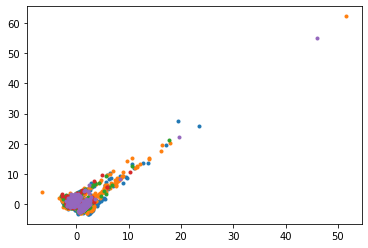

In [281]:
#put PCA data into dataframe for vizualization
pc = pd.DataFrame(principalComponents,columns=['var0','var1'])
pc['price'] = pd.Series(y)
bins = 5
pc['bin'] = pd.cut(pc['price'], bins=bins, labels=[i for i in range(1,bins+1)])

groups = pc.groupby('bin')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.var0, group.var1, marker='o', linestyle='', ms=3, label=name)
#ax.legend(numpoints=1)

Text(0, 0.5, 'Explained Variance Ratio')

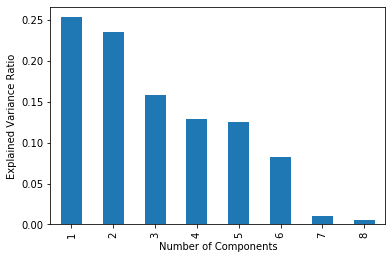

In [286]:
#Find best PCA dimsionality reduction
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

ev = pd.DataFrame(pca.explained_variance_ratio_ , columns=['explained_variance_ratio'], index=[1,2,3,4,5,6,7,8])
ax = ev.plot(kind='bar',legend=False)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance Ratio")

In [287]:
#best pca value
pca_best = PCA(n_components=6, random_state=2)
X_pca_best = pca_best.fit_transform(X)

Text(0, 0.5, 'Kurtosis')

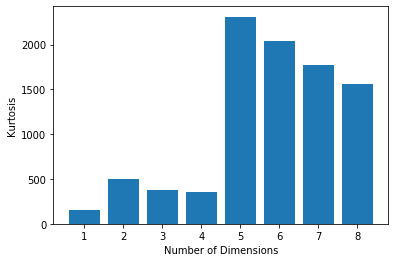

In [289]:
#find best ica for dimensionality reduction
n_list = [1, 2, 3, 4, 5, 6, 7, 8]
kurtosis_list = []

for n in n_list:
    ica = FastICA(random_state=2, n_components=n)
    X_ica = pd.DataFrame(ica.fit_transform(X))
    kurtosis_list.append(X_ica.kurtosis(axis=0).abs().mean())

plt.bar(n_list,kurtosis_list)
plt.xlabel("Number of Dimensions")
plt.ylabel("Kurtosis")

In [168]:
ica_best = FastICA(random_state=2, n_components=5)
X_ica_best = ica_best.fit_transform(X)

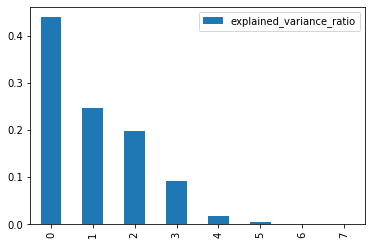

In [164]:
#Find best n for Random Projection
randproj = GaussianRandomProjection(n_components=8, random_state=2)
X_randproj = randproj.fit_transform(X)
n_samples, n_features = X_randproj.shape
U, S, V = linalg.svd(X_randproj, full_matrices=False)
exp_var = (S ** 2) / (n_samples - 1)
total_var = exp_var.sum()

ev = pd.DataFrame(exp_var / total_var, columns=['explained_variance_ratio'])
ev.plot(kind='bar')   

In [165]:
randproj_best = GaussianRandomProjection(n_components=4, random_state=2)
X_randproj_best = randproj_best.fit_transform(X)

In [135]:
#use a decision tree to do feature reduction
depth_list = range(5,21,3)
min_leaf_list = [0.001, .01, .05]
criterion_list = ['mse', 'mae']

reg = DecisionTreeRegressor(random_state=2)

#find best decision tree
gs = GridSearchCV(reg, cv=3, verbose=1, iid=False, param_grid={
    'max_depth': depth_list,
    'min_samples_leaf': min_leaf_list,
    'criterion': criterion_list
    })

gs.fit(X, y)
print(gs.best_estimator_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.01,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=2, splitter='best')


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  5.3min finished


In [102]:
#find the columns that decision tree found useful
dt_best_features = list(set(list(pd.DataFrame(X).columns[gs.best_estimator_.tree_.feature])))

[0, 1, 2, 4, 5, 6, 7]

In [109]:
#filter new datset to only the features the decision tree found useful
X_dt_best = X[:,dt_best_features]

Text(0, 0.5, 'Sum of squared distance')

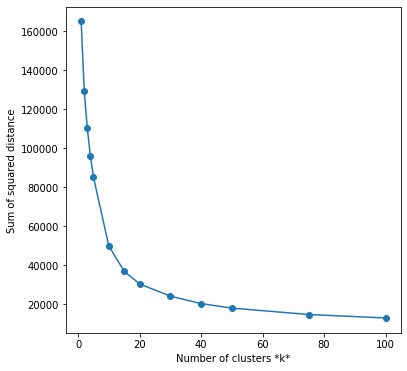

In [166]:
#K means on original dataset (normalized)
n_list = [1,2,3,4,5,10,15,20,30,40,50,75,100]
sse = []

for n in n_list:
    kmeans = KMeans(n_clusters=n, random_state=2)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(n_list, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Text(0, 0.5, 'Homogeneity')

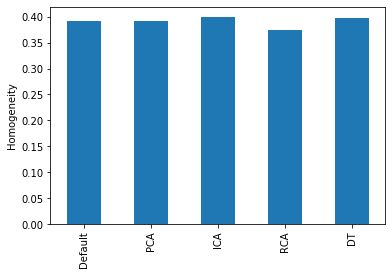

In [274]:
#show how feature reduction affects k means
sse = []

kmeans = KMeans(n_clusters=15, random_state=2)
kmeans.fit(X)
X_cluster = np.hstack((X,np.reshape(kmeans.predict(X), (-1,1))))
sse.append({'Reduction Type':'Default','Homogeniety':homogeneity_score(kmeans.predict(X),y)})
#PCA
kmeans.fit(X_pca_best)
X_pca_cluster = np.hstack((X,np.reshape(kmeans.predict(X_pca_best), (-1,1))))
sse.append({'Reduction Type':'PCA','Homogeniety':homogeneity_score(kmeans.predict(X_pca_best),y)})
#ICA
kmeans.fit(X_ica_best)
X_ica_cluster = np.hstack((X,np.reshape(kmeans.predict(X_ica_best), (-1,1))))
sse.append({'Reduction Type':'ICA','Homogeniety':homogeneity_score(kmeans.predict(X_ica_best),y)})
#RCA
kmeans.fit(X_randproj_best)
X_rca_cluster = np.hstack((X,np.reshape(kmeans.predict(X_randproj_best), (-1,1))))
sse.append({'Reduction Type':'RCA','Homogeniety':homogeneity_score(kmeans.predict(X_randproj_best),y)})
#DT
kmeans.fit(X_dt_best)
X_dt_cluster = np.hstack((X,np.reshape(kmeans.predict(X_dt_best), (-1,1))))
sse.append({'Reduction Type':'DT','Homogeniety':homogeneity_score(kmeans.predict(X_dt_best),y)})


#plot the results
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('Homogeneity')



In [275]:
sse_df

,Homogeniety,Reduction Type
0,0.391675,Default
1,0.391046,PCA
2,0.399468,ICA
3,0.375264,RCA
4,0.396787,DT


In [278]:
#expectation maximization
n_list = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,75,100]
log = []

for n in n_list:
    expmax = GaussianMixture(n_components=n, random_state=2)
    expmax.fit(X)
    log.append(expmax.lower_bound_) 

Text(0, 0.5, 'Lower bound log-likelihood')

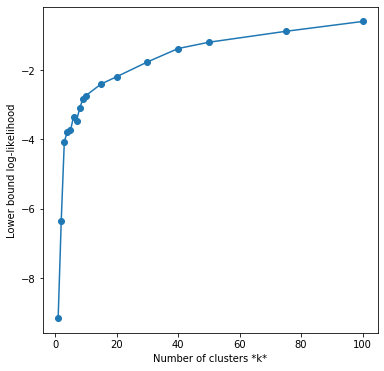

In [279]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(n_list, log, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Lower bound log-likelihood')

In [276]:
#show how feature reduction affects expectation maximization
sse = []

expmax = GaussianMixture(n_components=15, random_state=2)
#default data
expmax.fit(X)
sse.append({'Reduction Type':'Default','Homogeneity':homogeneity_score(expmax.predict(X),y)})
#PCA
expmax.fit(X_pca_best)
sse.append({'Reduction Type':'PCA','Homogeneity':homogeneity_score(expmax.predict(X_pca_best),y)})
#ICA
expmax.fit(X_ica_best)
sse.append({'Reduction Type':'ICA','Homogeneity':homogeneity_score(expmax.predict(X_ica_best),y)})
#RCA
expmax.fit(X_randproj_best)
sse.append({'Reduction Type':'RCA','Homogeneity':homogeneity_score(expmax.predict(X_randproj_best),y)})
#DT
expmax.fit(X_dt_best)
sse.append({'Reduction Type':'DT','Homogeneity':homogeneity_score(expmax.predict(X_dt_best),y)})


Text(0, 0.5, 'Homogeneity')

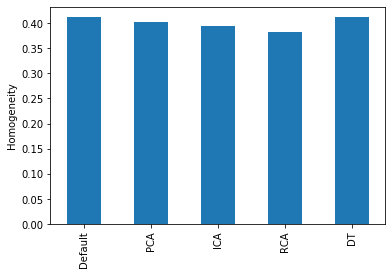

In [277]:
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('Homogeneity')

In [273]:
sse_df

,Homogeneity,Reduction Type
0,0.389327,Default
1,0.355717,PCA
2,0.361010,ICA
3,0.335558,RCA
4,0.383658,DT


In [266]:
#Nerual Networks
sse = []

rows = np.sort(np.random.choice(X.shape[0], round(X.shape[0]*0.7), replace=False))
not_rows = [x for x in range(X.shape[0]) if x not in rows]


nn = MLPRegressor((6,8),solver='lbfgs', random_state = 2)
nn.fit(X[rows],y[rows])
sse.append({'Reduction Type':'Default','R^2':nn.score(X[not_rows],y[not_rows])})
#PCA
nn.fit(X_pca_best[rows],y[rows])
sse.append({'Reduction Type':'PCA','R^2':nn.score(X_pca_best[not_rows],y[not_rows])})
#ICA
nn.fit(X_ica_best[rows],y[rows])
sse.append({'Reduction Type':'ICA','R^2':nn.score(X_ica_best[not_rows],y[not_rows])})
#RCA
nn.fit(X_randproj_best[rows],y[rows])
sse.append({'Reduction Type':'RCA','R^2':nn.score(X_randproj_best[not_rows],y[not_rows])})
#DT
nn.fit(X_dt_best[rows],y[rows])
sse.append({'Reduction Type':'DT','R^2':nn.score(X_dt_best[not_rows],y[not_rows])})

Text(0, 0.5, 'R^2')

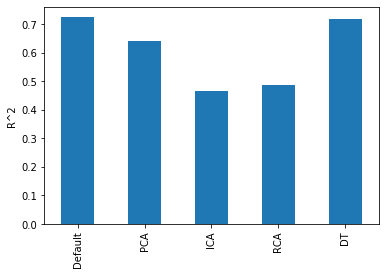

In [267]:
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('R^2')

In [268]:
sse_df

,R^2,Reduction Type
0,0.724799,Default
1,0.641377,PCA
2,0.463943,ICA
3,0.487470,RCA
4,0.717141,DT


In [259]:
sse = []

#NN with cluster feature included
nn = MLPRegressor((6,8),solver='lbfgs', random_state = 2)
nn.fit(X_cluster[rows],y[rows])
sse.append({'Reduction Type':'Default','R^2':nn.score(X_cluster[not_rows],y[not_rows])})
#PCA
nn.fit(X_pca_cluster[rows],y[rows])
sse.append({'Reduction Type':'PCA','R^2':nn.score(X_pca_cluster[not_rows],y[not_rows])})
#ICA
nn.fit(X_ica_cluster[rows],y[rows])
sse.append({'Reduction Type':'ICA','R^2':nn.score(X_ica_cluster[not_rows],y[not_rows])})
#RCA
nn.fit(X_rca_cluster[rows],y[rows])
sse.append({'Reduction Type':'RCA','R^2':nn.score(X_rca_cluster[not_rows],y[not_rows])})
#DT
nn.fit(X_dt_cluster[rows],y[rows])
sse.append({'Reduction Type':'DT','R^2':nn.score(X_dt_cluster[not_rows],y[not_rows])})

Text(0, 0.5, 'R^2')

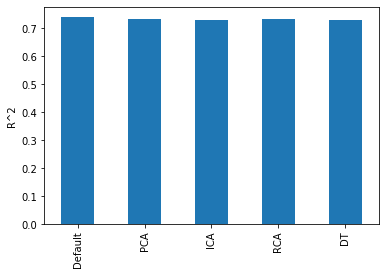

In [260]:
sse_df = pd.DataFrame(sse)
ax = sse_df.plot(kind='bar',legend=False)
ax.set_xticklabels(sse_df['Reduction Type'])
ax.set_ylabel('R^2')

In [261]:
sse_df

,R^2,Reduction Type
0,0.739076,Default
1,0.732118,PCA
2,0.727846,ICA
3,0.730330,RCA
4,0.726554,DT
